In [31]:
import pandas as pd
import xgboost as xgb
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, make_scorer, f1_score, roc_auc_score, precision_score, recall_score, matthews_corrcoef, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

#Model Development

##Data Processing

In [2]:
df = pd.read_csv("drive/MyDrive/SCB-data/fraud_mock.csv")
processed_df = df.copy()

In [3]:
#exclude irrelevant columns: is_flagged_fraud, src_acc, dst_acc
processed_df.drop(columns=['is_flagged_fraud', 'src_acc', 'dst_acc'], axis=1, inplace=True)

In [4]:
#only include fraud susceptible transaction types
transac_types_to_include = ['CASH_OUT', 'TRANSFER']
processed_df = processed_df[processed_df['transac_type'].isin(transac_types_to_include)]

In [5]:
#include hour_of_day, 24hr time of day the transaction was made
processed_df.loc[:, 'hour_of_day'] = processed_df['time_ind']%24

In [6]:
#encode categorical data in transac_type to numerical
processed_df['transac_type']=processed_df['transac_type'].map({
   'CASH_OUT': 0,
   'TRANSFER': 1
})

In [91]:
#process numerical data
# numeric_columns = ['time_ind', 'hour_of_day', 'src_bal', 'src_new_bal', 'dst_bal', 'dst_new_bal']

# for column in numeric_columns:
#     plt.figure(figsize=(6, 4))
#     sns.boxplot(x=np.log1p(processed_df[column]))  # Applying log transformation
#     plt.title(f'Box plot for log-transformed {column}')
#     plt.show()

In [92]:
# for column in numeric_columns:
#     processed_df[column] = np.log1p(processed_df[column])

# robust_scaler = RobustScaler()
# processed_df[numeric_columns] = robust_scaler.fit_transform(processed_df[numeric_columns])

In [7]:
processed_df.head()

,time_ind,transac_type,amount,src_bal,src_new_bal,dst_bal,dst_new_bal,is_fraud,hour_of_day
2,1,1,181.00,181.0,0.0,0.0,0.00,1,1
3,1,0,181.00,181.0,0.0,21182.0,0.00,1,1
15,1,0,229133.94,15325.0,0.0,5083.0,51513.44,0,1
19,1,1,215310.30,705.0,0.0,22425.0,0.00,0,1
24,1,1,311685.89,10835.0,0.0,6267.0,2719172.89,0,1


In [8]:
processed_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2770409 entries, 2 to 6362619
Data columns (total 9 columns):
 #   Column        Dtype  
---  ------        -----  
 0   time_ind      int64  
 1   transac_type  int64  
 2   amount        float64
 3   src_bal       float64
 4   src_new_bal   float64
 5   dst_bal       float64
 6   dst_new_bal   float64
 7   is_fraud      int64  
 8   hour_of_day   int64  
dtypes: float64(5), int64(4)
memory usage: 211.4 MB


In [9]:
print(f"Total count: {processed_df.shape[0]}")

Total count: 2770409


##Train Test Split


Since our data is highly class-imbalanced, we will employ steps to ensure that the training on this dataset is effective.

In [36]:
X = processed_df[['time_ind', 'transac_type', 'amount', 'src_bal', 'src_new_bal', 'dst_bal', 'dst_new_bal','hour_of_day']]
y = processed_df['is_fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

The stratify parameter is used to maintain proportion of positive and negative class in the train and test sets.

In [37]:
undersampler = RandomUnderSampler(sampling_strategy=0.1)
X_train_under_sampled, y_train_under_sampled = undersampler.fit_resample(X_train, y_train)

In [12]:
smote=SMOTE()
X_train_over_sampled,y_train_over_sampled=smote.fit_resample(X_train,y_train)

##Model Selection

Since the data set has high class imabalance, we will put our focus on ensemble models to address the problem.

In [38]:
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True)

###Random Forest

In [39]:
rf_model = RandomForestClassifier()

params = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced']
}

scoring = {
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score),
    'recall': make_scorer(recall_score)
}

random_search = RandomizedSearchCV(rf_model, param_distributions=params, n_iter=5, scoring=scoring, refit='f1', cv=stratified_kfold)
random_search.fit(X_train_under_sampled, y_train_under_sampled)
print("Best Hyperparameters:", random_search.best_params_)

Best Hyperparameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': None, 'class_weight': 'balanced'}


In [40]:
best_params = random_search.best_params_
best_rf_model = RandomForestClassifier(**random_search.best_params_)
best_rf_model.fit(X_train_under_sampled, y_train_under_sampled)

RandomForestClassifier(class_weight='balanced', min_samples_leaf=4,
                       min_samples_split=10)

In [41]:
def plot_confusion_matrix(y_true, y_pred, title):
    conf_matrix = confusion_matrix(y_true, y_pred)
    print(conf_matrix)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552439
           1       0.38      0.96      0.54      1643

    accuracy                           1.00    554082
   macro avg       0.69      0.98      0.77    554082
weighted avg       1.00      1.00      1.00    554082

[[549832   2607]
 [    71   1572]]


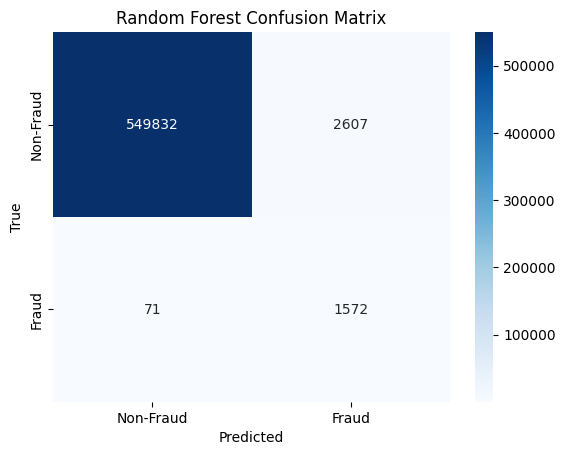

In [42]:
y_pred = best_rf_model.predict(X_test)
predicted_probabilities = best_rf_model.predict_proba(X_test)
print(classification_report(y_test, y_pred))
plot_confusion_matrix(y_test, y_pred, 'Random Forest Confusion Matrix')
plt.show()

###XGBoost

In [47]:
xgb_model = xgb.XGBClassifier()

param_grid = {
    'n_estimators': [100, 200, 250, 300, 350],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 1, 5],
    'scale_pos_weight': [1, 5, 10, 15],
    'alpha': [0, 0.1, 0.5, 1],
    'lambda': [0, 0.1, 0.5, 1]
}

scoring = {
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score),
    'recall': make_scorer(recall_score)
}

random_search_xgb = RandomizedSearchCV(xgb_model, param_distributions=param_grid, n_iter=10, scoring=scoring, refit='f1', cv=stratified_kfold)

random_search_xgb.fit(X_train_under_sampled, y_train_under_sampled)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           feature_weights=None, gamma=None,
                                           gr...
                                        'lambda': [0, 0.1, 0.5, 1],
                                        'learning_rate': [0.01, 0.1, 0.2, 0.3],
                                        'max_depth': [3, 4, 5],
                                        'n_estimators': [100, 200, 250, 300,
                                                         350],
                                        'scale_pos_weight': [1, 5, 10, 15],
                                        'subsample': [0.8, 0.9, 1.0]},
                   refit='f1',
                   scoring={'f1': make_scorer(f1_score, response_method='predict'),
                            'recall': make_scorer(recall_score, response_method='predict'),
                            'roc_auc': make_scorer(roc_auc_score, response_method='predict')})

In [48]:
best_xgb_params = random_search_xgb.best_params_
best_xgb_model = xgb.XGBClassifier(**best_xgb_params)
best_xgb_model.fit(X_train_under_sampled, y_train_under_sampled)

XGBClassifier(alpha=0.1, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=1, grow_policy=None,
              importance_type=None, interaction_constraints=None, lambda=0.1,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200, ...)

In [49]:
print(best_xgb_params)

{'subsample': 0.9, 'scale_pos_weight': 1, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'lambda': 0.1, 'gamma': 1, 'colsample_bytree': 0.9, 'alpha': 0.1}


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552439
           1       0.56      0.97      0.71      1643

    accuracy                           1.00    554082
   macro avg       0.78      0.98      0.86    554082
weighted avg       1.00      1.00      1.00    554082

[[551210   1229]
 [    54   1589]]


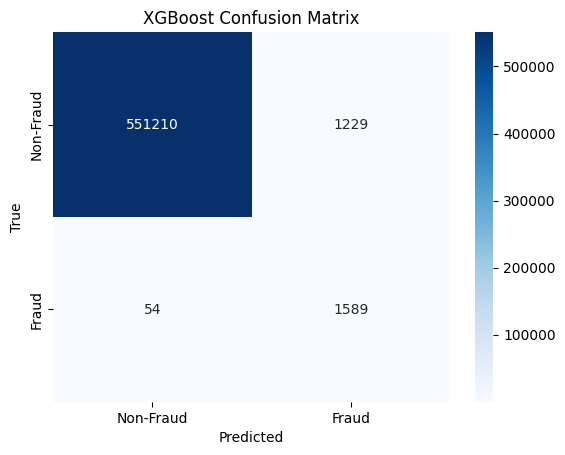

In [50]:
y_pred = best_xgb_model.predict(X_test)
predicted_probabilities = best_xgb_model.predict_proba(X_test)
print(classification_report(y_test, y_pred))
plot_confusion_matrix(y_test, y_pred, 'XGBoost Confusion Matrix')
plt.show()

In [51]:
best_xgb_model.save_model('fraud_detection.model')

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:1028: UserWarning: [05:54:28] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
